In [20]:
import numpy as np
import pandas as pd
import scipy
import scipy.spatial
import tqdm
import os
import os.path as osp
import matplotlib.pyplot as plt
import tables

# Unifying coordinates

In [52]:
coords_1 = pd.read_csv('yodai_data/TableS0_Mbcoords.csv')
coords_25 = pd.read_csv('yodai_data/TableS0_25kbcoords.csv')

In [53]:
coords_1.tail()

Region ID      Name  Channel Chrom      Start        End  Chrom ID
2455       2456     Gpm6b        2  chrX  166226411  166251411        20
2456       2457  chrX-#59        1  chrX  167225000  167250000        20
2457       2458      Tlr7        2  chrX  167318058  167343058        20
2458       2459  chrX-#60        1  chrX  169025000  169050000        20
2459       2460      Mid1        2  chrX  169672699  169697699        20

In [54]:
coords_25.head()

Region ID             Name  Channel Chrom      Start        End  Chrom ID
0          1  chr1-HighRes-#1        3  chr1  135600000  135625000         1
1          2  chr1-HighRes-#2        3  chr1  135625000  135650000         1
2          3  chr1-HighRes-#3        3  chr1  135650000  135675000         1
3          4  chr1-HighRes-#4        3  chr1  135675000  135700000         1
4          5  chr1-HighRes-#5        3  chr1  135700000  135725000         1

# Converting and unifying DNA data with IF data

Some main tasks:
* Convert locus ID to a numerical genomic distance measure, previously computed by normalizing locus start coordinates to 2^16 / length of chromosome 1 (so that all loci are between 0 and 2^16, similar to IF intensities)
* Unify spatial coordinate system between IF and DNA data. Because I processed the IF data first, this requires obtaining the bounding box from the (raw?) IF data and subtracting the minimum x and y coordinates. 
* Pivoting the data to a 'wide' format with one dimension per chromosome, with all except one being 0. Each point is represented by the normalized (0-2^16) genomic coordinate in the respective chromosome dimension, as well as its 3D coordinates.
* Split into individual files for each cell. Though this is not necessary for storage, it would match the IF format. Maybe it is ok not to do this, since this data is ~1000 times smaller than the IF data due to its sparsity.

## Notes on dimensions
Representing this dataset as a high-dimensional point cloud requires mathematicizing the notion of genomic locus. The current way I think to do this is to have one dimension for each chromosome, where genomic distances within a chromosome are meaningfully represented. Having one dimension with some indicator for each locus is another option, but this requires concatenating all chromosomes in this space, when physically/biologically this is unrealistic and creates weird boundary problems - what is the "genomic distance" between the end of chr1 and the start of chr2? But a downside of doing it this way is that the chromosomal dimensions aren't completely independent - at any super-resolved voxel, only *one* dimension can be nonzero. So it has a constrained zero norm. I am not yet completely sure how this affects the topology of the space or how exactly to encode it mathematically. 

Another potential problem is missing data - the measurement of genomic points is very coarse-grained, and most voxels are all zeros. This is not necessarily because no locus is present there, but because we only measure small regions every 1 Mb. Perhaps comparing topological properties between the 1 Mb and 25 kb resolution sets would be informative to see if this is an issue.

Another weird thing is the inequivalence of the different dimensions. Spatial coordinates are obviously much different from pixel intensity of different protein markers and from genomic coordinates. It's like you would need different metrics on each "subspace". Is there such a thing as a mixed-metric space? Can we just arbitrarily define complicated distance functions? Euclidean on x/y/z, probably individual L1 for each genomic dimension (again, what's the distance between two loci on different chromosomes?), and also L1 or some other metric for the IF staining. Actually, using L1 on the genomic distance is problematic because it implies a point with chr1-region 1 is "closer" to an empty point or a point with chr2-region X than a point with chr1-region 100 would be - this doesn't make sense. So we need to use a discrete metric - two points not having the same chromosome have distance 1 or whatever the maximum is. The number of nonzero elements in their difference vector. But at the same time, we *can* define 1D genomic distance between two points on one chromosome, so it seems like we want a mixed metric. But this seems very unrigorous.

One could think of very exotic metrics on genomic space such as sequence conservation among different loci, or phylogenetic distance, or feature distances using some known sequence motifs such as CTCF binding sites...

Matt talked about keeping the three "subspaces" - spatial coordinate, genomic coordinate, and IF intensity - "orthogonal" meaning in some way they don't interact in any complicated way. But how this works mathematically or if it makes sense for what we want to learn isn't so clear. 

Another option is to think like a Hi-C map and not worry about the meaning of genomic distance, just the spatial coordinates; genomic location can then just be metadata associated with each point that doesn't directly get clustered or acted on by topological algorithms. 

Another option is to formalize one genomic dimension by unconnected open sets - the origin (no locus), each chromosome is an open set where distance in an open set is regular euclidean in 1D while distance between loci on different chromosomes or between the origin and any locus is infinite.

Although, really what we want to use the genomic distance (chromosome distance) for is to see if there are any relationships between spatial positions of multiple loci on the same chromosome with their genomic positions. Inter-chromosomal interactions aren't necessarily important for this. One way that interchromosomal genomic distance could be important in a simple way is just classifying regions in a few bins - intragenic, intergenic, centromeric, telomeric for example. This would induce equivalent metrics on each chromosome dimension and might actually capture interesting interaction between chromosomes (i.e. if genic or telomeric regions cluster together), and between chromosomes and nuclear bodies. A simple discrete distance could be used.


For inter-chromosomal interactions on a large scale, it could be good to convert each chromosome into an IF-like intensity format using either local density of that chromosome's loci at each voxel or maybe just sum all loci for each chromosome and apply a blur to them to generate an image.

# Load DNA data and convert from pixels to nanometers

I think it is justified to round to nearest integer number of nanometers. We only know the positions within ~40 nm, and so this gives a lot of buffer without keeping unnecessary digits.

The pixel sizes are derived from the manuscript Methods section.

After some testing, it seems like using a 16 bit form for the distance to save space is okay. Measured in nanometers, two points 10 micron away in all 3 dimensions would be $\sqrt{3}\,10^4 \approx 17320$ nm apart. They would have to be ~37.8 um apart in all three dimensions to exceed 2^16.

In [452]:
np.sqrt(np.dot([37000, 37000, 37000], [37000, 37000, 37000]))

64085.87988004846

In [2]:
def xy_units(x):
    return int(103. * float(x))
def z_units(z):
    return int(250. * float(z))

In [3]:
data_dir = 'yodai_data/DNAseqFISH+/'

In [4]:
rep1_df = pd.read_csv(
    osp.join(data_dir, 'DNAseqFISH+1Mbloci-E14-replicate1.csv'),
    converters={'x': xy_units, 'y': xy_units, 'z': z_units})

In [18]:
pd.DataFrame.from_records(list(rep1_df.groupby(['fov', 'cellID']).groups.keys()), columns=['fov', 'cellID'])

fov  cellID
0      0       1
1      0       2
2      0       3
3      0       4
4      0       5
..   ...     ...
196    4      27
197    4      28
198    4      29
199    4      30
200    4      31

[201 rows x 2 columns]

In [45]:
None in rep1_df.columns

False

In [46]:
rep1_df.head(10)

fov  cellID  channel    geneID       x      y     z  seeds  intensity
0    0       1        1   chr1-#1  174118  17178  2391      5       1690
1    0       1        1  chr1-#11  174259  15257  2539      5       1692
2    0       1        1  chr1-#13  165982  20859  2496      4       1611
3    0       1        1  chr1-#13  175170  14861  2373      4       1701
4    0       1        1  chr1-#13  165188  19091  2174      5       1604
5    0       1        1  chr1-#13  165531  20354  2130      4       1607
6    0       1        1  chr1-#14  165345  21178  2213      5       1605
7    0       1        1  chr1-#15  165392  20886  2517      5       1606
8    0       1        1  chr1-#15  164847  18449  2205      4       1600
9    0       1        1  chr1-#15  164997  21609  2391      5       1602

In [47]:
rep1_merged = pd.merge(
    rep1_df, 
    coords_1[['Name', 'Region ID', 'Chrom ID']], 
    left_on='geneID',
    right_on='Name', 
    how='inner',
)

NameError: name 'coords_1' is not defined

In [ ]:
np.zeros(100, dtype=np.uint16).nbytes

In [ ]:
for a in tester.keys():
    print({a:tester[a].values})

In [ ]:
tester = pd.DataFrame({'fov': [0, 2], 'cellID': [1, 20]})

tester

In [ ]:
'_'.join(f'{k}{v}' for k, v in {'a': 1, 'b': 2}.items())

In [ ]:
rep1_df.query('(fov, cellID) in [(0, 1), (2, 3)]')

In [ ]:
tester.columns.values

In [ ]:
os.remove

In [ ]:
OSError

In [ ]:
def locs_pairwise_to_h5(df, filename, title):
    '''
    Takes a dataframe of DNA localizations and creates an HDF5 file with the following structure:
    /root/fov{X}_cell{Y}/ : group for each cell in each FOV
    /root/fov{X}_cell{Y}/locus_order : array of locus IDs in the order they were in to compute the distance matrix
    /root/fov{X}_cell{Y}/pdists : N*(N-1)/2-length vector of pairwise distances. result of scipy.spatial.distance.pdist. Can be converted to square form.
    Pairwise distances are stored as np.uint16, allowing roughly 1 nm precision for these data.
    Saves to disk after each cell so that memory doesn't fill up.
    '''
    
    df = df.sort_values(by=['fov', 'cellID', 'channel', 'Region ID'])
    df_grp = df.groupby(['fov', 'cellID'])
    
    
    filters = tables.Filters(complevel=9)
    h5_file = tables.open_file(filename, mode='a', title=title, filters=filters)
    
    
    # Loop through each unique cell/fov combo
    for info, group in tqdm.tqdm(df_grp):

        group_name = f'fov{info[0]}_cell{info[1]}'

        cell = h5_file.create_group('/', group_name)

        # Order of loci to recover distance matrix indices
        locus_order = group['Region ID'].values    
        dist_vec = scipy.spatial.distance.pdist(group[['x', 'y', 'z']].values).astype(np.uint16)

        order_carray = h5_file.create_carray(cell, 
                                             'locus_order', 
                                             tables.UInt16Atom(), 
                                             shape=(len(locus_order),), 
                                             filters=filters)
        
        pdist_carray = h5_file.create_carray(cell, 
                                             'pdists', 
                                             tables.UInt16Atom(), 
                                             shape=(len(dist_vec),), 
                                             filters=filters)

        
        order_carray[:] = locus_order
        pdist_carray[:] = dist_vec

        h5_file.flush()

        del dist_vec
        
    return h5_file
        

## Rep1 1 Mb Pairwise Distances

In [ ]:
h5_1mb_rep1 = locs_pairwise_to_h5(rep1_merged, './DNA_converted/Rep1_1Mb_pdists.h5', 'DNA Rep1 1Mb Pairwise Distances (nm)')

In [ ]:
def max_of_maxes(h5):
    return max([ g.pdists.read().max() for g in h5.root ])

def min_of_mins(h5):
    return min([ g.pdists.read().min() for g in h5.root ])

In [ ]:
max_of_maxes(h5_1mb_rep1)

In [ ]:
h5_1mb_rep1.close()

In [ ]:
del rep1_df, rep1_merged

## Rep2 1 Mb Pairwise Distances

In [ ]:
rep2_df = pd.read_csv(
    osp.join(data_dir, 'DNAseqFISH+1Mbloci-E14-replicate2.csv'),
    converters={'x': xy_units, 'y': xy_units, 'z': z_units})

rep2_merged = pd.merge(
    rep2_df, 
    coords_1[['Region ID', 'Name', 'Chrom ID']], 
    left_on='geneID', 
    right_on='Name', 
    how='inner'
)

In [ ]:
rep2_merged.head(10)

In [ ]:
h5_1mb_rep2 = locs_pairwise_to_h5(rep2_merged, './DNA_converted/Rep2_1Mb_pdists.h5', 'DNA Rep2 1Mb Pairwise Distances (nm)')

In [ ]:
max_of_maxes(h5_1mb_rep2)

In [ ]:
h5_1mb_rep2.close()

In [ ]:
del  h5_1mb_rep1, h5_1mb_rep2, rep1_df, rep2_df

## Rep1 25 kb Pairwise Distances

In [ ]:
rep1_25 = pd.read_csv(
    osp.join(data_dir, 'DNAseqFISH+25kbloci-E14-replicate1.csv'), 
    usecols=['fov', 'cellID', 'channel', 'regionID (hyb1-60)', 'x', 'y', 'z', 'chromID', 'labelID'],
    converters={'x': xy_units, 'y': xy_units, 'z': z_units})

In [ ]:
rep1_25.tail()

In [ ]:
# This must match up with the name given in the coords file - 'chrX-HighRes-#y'
def gen_locus_name(df):
    if df['chromID'] == 20:
        chrom = 'X'
    else:
        chrom = str(df['chromID'])
    return 'chr{}-HighRes-#{:.0f}'.format(chrom, df['regionID (hyb1-60)'])

rep1_25['geneID'] = rep1_25.apply(gen_locus_name, axis=1)

In [ ]:
rep1_25.head()

In [ ]:
rep1_25_merged = pd.merge(
    rep1_25, 
    coords_25[['Region ID', 'Name', 'Chrom ID']], 
    left_on='geneID', 
    right_on='Name',
    how='inner'
)

In [ ]:
rep1_25_merged.head()

In [ ]:
h5_25kb_rep1 = locs_pairwise_to_h5(rep1_25_merged, './DNA_converted/Rep1_25kb_pdists.h5', 'DNA Rep1 25kb Pairwise Distances (nm)')

In [ ]:
sorted(h5_25kb_rep1.root.fov0_cell43.pdists.read())[:10]

In [ ]:
max_of_maxes(h5_25kb_rep1)

In [ ]:
h5_25kb_rep1.close()

## Rep2 25kb pairwise distances

In [ ]:
rep2_25 = pd.read_csv(
    osp.join(data_dir, 'DNAseqFISH+25kbloci-E14-replicate2.csv'), 
    usecols=['fov', 'cellID', 'channel', 'regionID (hyb1-60)', 'x', 'y', 'z', 'chromID', 'labelID'],
    converters={'x': xy_units, 'y': xy_units, 'z': z_units}
)

In [ ]:
rep2_25.head()

In [ ]:
rep2_25['geneID'] = rep2_25.apply(gen_locus_name, axis=1)

In [ ]:
rep2_25_merged = pd.merge(
    rep2_25, 
    coords_25[['Region ID', 'Name', 'Chrom ID']], 
    left_on='geneID', 
    right_on='Name',
    how='inner'
)

In [ ]:
h5_25kb_rep2 = locs_pairwise_to_h5(rep2_25_merged, './DNA_converted/Rep2_25kb_pdists.h5', 'DNA Rep2 25kb Pairwise Distances')

In [ ]:
max_of_maxes(h5_25kb_rep2)

In [ ]:
h5_25kb_rep2.close()

In [ ]:
del rep1_25, rep2_25, rep1_25_merged, rep2_25_merged

# Functions for accessing DNA data

In [48]:
class PDistCells:
   

    def __init__(self,
                filename,
                 coords_df=None
                ):
        self.h5 = tables.open_file(filename, 'r')
        self.coords_df = coords_df
        
    
    def get_cell(self, fov, cell):
        node_name = f'fov{fov}_cell{cell}'
        
        self.current_cell = self.h5.get_node(f'/{node_name}')
    
        return self.current_cell
    
    def gen_square_df(self, fov=None, cell=None, coords_df=None, key='Region ID'):

        if fov is None or cell is None:
            cell = self.current_cell
        else:
            cell = self.get_cell(fov, cell)
        
        order = cell.locus_order.read()
        dist_mat = scipy.spatial.distance.squareform(cell.pdists.read())
        

        
        self.current_matrix = pd.DataFrame(
            dist_mat, 
            index=order,  
            columns=order
        )
        
        if coords_df is not None:
            self.add_coords(self.current_matrix, coords_df, key)
        
        return self.current_matrix
    
    def add_coords(self, matrix=None, coords_df=None, key=None):
        
        if matrix is not None:
            self.current_matrix = matrix
            
        if coords_df is None:
            raise ValueError('Must specify a coordinate dataframe with columns `Region ID` and `Chrom ID`')
        
        self.coords_df = coords_df
        self.coords_index = pd.MultiIndex.from_frame(coords_df[['Chrom ID', 'Region ID']])
        
        multi_index = pd.MultiIndex.from_frame(
            pd.merge(coords_df, self.current_matrix.index.to_frame(name='Region ID'), 
                     on='Region ID', how='right')[['Chrom ID', key]]
        )
        
        multi_columns = pd.MultiIndex.from_frame(
            pd.merge(coords_df, self.current_matrix.columns.to_frame(name='Region ID'), 
                     on='Region ID', how='right')[['Chrom ID', key]]
        )
        
        self.current_matrix.index = multi_index
        self.current_matrix.columns = multi_columns
        
        self.current_matrix.sort_index(axis=0, level=0, sort_remaining=False, inplace=True)
        self.current_matrix.sort_index(axis=1, level=0, sort_remaining=False, inplace=True)
        
    def collapse_dups(self, agg=np.mean):
        
        result = self.current_matrix.groupby(level=[0,1], axis=0).agg(agg).astype(np.uint16)
        result = result.groupby(level=[0,1], axis=1).agg(agg).astype(np.uint16)

        
        self.current_matrix = result
        
        return self.current_matrix
    
    def reindex_coords(self, coords_df=None):
        
        if coords_df is None:
            coords_df = self.coords_df
        else:
            self.add_coords(coords_df=coords_df)
        
        # Note that by inserting NaNs the values in the DF get casted to Float64.
        self.current_matrix = self.current_matrix.reindex(self.coords_index, axis=0)
        self.current_matrix = self.current_matrix.reindex(self.coords_index, axis=1)
        
        # Will have NaNs and be a large datatype!
        return self.current_matrix

In [49]:
def singlecell_to_ensemble(filename, dest, func=np.median, coords_df=None, output_dtype=np.uint16):
    '''
    Takes one of the H5 archives containing pairwise distance matrices from cells,
    and loads them while keeping memory usage reasonable.
    Aggregates on a given function, typically median. Note that output_dtype by default is UInt16;
    if more precision or higher values are needed for your expected ouput, you must specify so.
    '''
    a = PDistCells(filename, coords_df=coords_df)
    ensemble_medians = []


    for cell in tqdm.tqdm(a.h5.root):
        a.current_cell = cell
        mat = a.gen_square_df(coords_df=coords_df)
        mat = a.collapse_dups()
        mat = a.reindex_coords()

        del a.current_matrix, a.current_cell

        mat = np.ma.array(mat.values, mask=mat.isna().values, fill_value=2**16-1, dtype=np.uint16)

        ensemble_medians.append(mat)

        del mat


    ensemble_applied = func(ensemble_medians, axis=0).astype(output_dtype)
    
    ensemble_df = pd.DataFrame(
        ensemble_applied, 
        index=pd.MultiIndex.from_frame(coords_df[['Chrom ID', 'Region ID']]), 
        columns=pd.MultiIndex.from_frame(coords_df[['Chrom ID', 'Region ID']])
    ) 

    ensemble_df.to_hdf(dest, dest.split('.')[0], complevel=9)
    
    return ensemble_df

In [50]:
b = PDistCells('DNA_converted/Rep1_25kb_pdists.h5')
mat1 = b.gen_square_df(0, 1)
#mat1_detected = mat1.index.value_counts().sort_index()
#b.current_matrix = b.current_matrix < 500
#mat1 = b.collapse_dups(np.sum)
#mat1 = b.reindex_coords().fillna(0)

In [57]:
mat1.index = pd.MultiIndex.from_frame(coords_25[['Chrom ID', 'Region ID']])

ValueError: Length mismatch: Expected axis has 1473 elements, new values have 1200 elements

In [87]:
mat1_detected.index = pd.Index([ i[1] for i in mat1_detected.index ])
mat1_detected.name = 'Region ID'
mat1_detected = mat1_detected.reindex(coords_25['Region ID'], fill_value=0)

In [181]:
a = PDistCells('DNA_converted/Rep2_1Mb_pdists.h5', coords_df=coords_1)
ensemble_medians = np.zeros((len(coords_1), len(coords_1)), dtype=float)

locus_counts = pd.Series(np.zeros(len(coords_1), dtype=float), coords_1['Region ID'])


for cell in tqdm.tqdm(a.h5.root):
    
    a.current_cell = cell
    mat = a.gen_square_df(coords_df=coords_1)
    
    mat_detected = mat.index.value_counts().sort_index()
    mat_detected.index = pd.Index([ i[1] for i in mat_detected.index ])
    mat_detected.name = 'Region ID'
    mat_detected = mat_detected.reindex(coords_1['Region ID'], fill_value=0)
    locus_counts = locus_counts + mat_detected
    
    a.current_matrix = a.current_matrix < 500
    mat = a.collapse_dups(np.sum)
    mat = a.reindex_coords().fillna(0)

    ensemble_medians += mat.values

    del mat, a.current_matrix, a.current_cell



#ensemble_applied = func(ensemble_medians, axis=0).astype(output_dtype)

245it [03:47,  1.08it/s]


In [182]:
locus_counts.max()

968.0

In [187]:
thresh_df = pd.DataFrame(
        ensemble_medians, 
        index=pd.MultiIndex.from_frame(coords_1[['Chrom ID', 'Region ID']]), 
        columns=pd.MultiIndex.from_frame(coords_1[['Chrom ID', 'Region ID']])
    ) 

In [188]:
thresh_df

Chrom ID               1                                                  \
Region ID            1      2      3      4      5      6     7     8      
Chrom ID Region ID                                                         
1        1          546.0  139.0  103.0   56.0   47.0   33.0  40.0  31.0   
         2          139.0  686.0  355.0  103.0   66.0   47.0  38.0  34.0   
         3          103.0  355.0  841.0  111.0   56.0   62.0  56.0  35.0   
         4           56.0  103.0  111.0  520.0  144.0   82.0  47.0  38.0   
         5           47.0   66.0   56.0  144.0  607.0  132.0  78.0  63.0   
...                   ...    ...    ...    ...    ...    ...   ...   ...   
20       2456         0.0    2.0    0.0    1.0    1.0    0.0   1.0   1.0   
         2457         0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
         2458         0.0    1.0    0.0    0.0    0.0    0.0   0.0   0.0   
         2459         1.0    0.0    0.0    0.0    1.0    0.0   0.0   0.0   
         2460         0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   

Chrom ID                        ...    20                                 \
Region ID           9     10    ...  2451  2452  2453  2454  2455   2456   
Chrom ID Region ID              ...                                        
1        1          30.0  28.0  ...   0.0   0.0   0.0   0.0   0.0    0.0   
         2          48.0  50.0  ...   0.0   0.0   1.0   0.0   0.0    2.0   
         3          37.0  57.0  ...   0.0   0.0   0.0   0.0   0.0    0.0   
         4          30.0  33.0  ...   0.0   0.0   0.0   0.0   0.0    1.0   
         5          44.0  33.0  ...   0.0   1.0   0.0   1.0   1.0    1.0   
...                  ...   ...  ...   ...   ...   ...   ...   ...    ...   
20       2456        0.0   0.0  ...  18.0  26.0  25.0  40.0  47.0  259.0   
         2457        0.0   0.0  ...   6.0  14.0  16.0  20.0  28.0   87.0   
         2458        0.0   0.0  ...   7.0  13.0  16.0  23.0  21.0  102.0   
         2459        1.0   0.0  ...   9.0  10.0  13.0  11.0  16.0   29.0   
         2460        0.0   0.0  ...   6.0  16.0  16.0  15.0  20.0   23.0   

Chrom ID                                        
Region ID            2457   2458   2459   2460  
Chrom ID Region ID                              
1        1            0.0    0.0    1.0    0.0  
         2            0.0    1.0    0.0    0.0  
         3            0.0    0.0    0.0    0.0  
         4            0.0    0.0    0.0    0.0  
         5            0.0    0.0    1.0    0.0  
...                   ...    ...    ...    ...  
20       2456        87.0  102.0   29.0   23.0  
         2457       228.0   90.0   27.0   22.0  
         2458        90.0  251.0   41.0   33.0  
         2459        27.0   41.0  246.0   67.0  
         2460        22.0   33.0   67.0  239.0  

[2460 rows x 2460 columns]

In [189]:
# sum of pairwise detection counts
locus_mat = np.outer(np.ones_like(locus_counts), locus_counts)

## Normalization of thresholded contacts
* Yodai and Long: Divide counts per pair by *product* of counts per individual constituent (square root?)
* Xiaowei: Divide counts per pair by *sum* of counts per individual constituent (divide by 2?)

In [225]:
thresh_df_norm = thresh_df / np.outer(locus_counts, locus_counts)

In [226]:
thresh_df_norm

Chrom ID                  1                                           \
Region ID               1         2         3         4         5      
Chrom ID Region ID                                                     
1        1          0.002116  0.000444  0.000284  0.000231  0.000163   
         2          0.000444  0.001808  0.000808  0.000350  0.000189   
         3          0.000284  0.000808  0.001654  0.000326  0.000139   
         4          0.000231  0.000350  0.000326  0.002276  0.000531   
         5          0.000163  0.000189  0.000139  0.000531  0.001888   
...                      ...       ...       ...       ...       ...   
20       2456       0.000000  0.000013  0.000000  0.000009  0.000007   
         2457       0.000000  0.000000  0.000000  0.000000  0.000000   
         2458       0.000000  0.000007  0.000000  0.000000  0.000000   
         2459       0.000009  0.000000  0.000000  0.000000  0.000008   
         2460       0.000000  0.000000  0.000000  0.000000  0.000000   

Chrom ID                                                              ...  \
Region ID               6         7         8         9         10    ...   
Chrom ID Region ID                                                    ...   
1        1          0.000145  0.000148  0.000109  0.000107  0.000098  ...   
         2          0.000170  0.000116  0.000098  0.000141  0.000145  ...   
         3          0.000194  0.000147  0.000088  0.000094  0.000143  ...   
         4          0.000383  0.000184  0.000142  0.000114  0.000123  ...   
         5          0.000520  0.000258  0.000198  0.000141  0.000104  ...   
...                      ...       ...       ...       ...       ...  ...   
20       2456       0.000000  0.000008  0.000007  0.000000  0.000000  ...   
         2457       0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         2458       0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         2459       0.000000  0.000000  0.000000  0.000008  0.000000  ...   
         2460       0.000000  0.000000  0.000000  0.000000  0.000000  ...   

Chrom ID                  20                                          \
Region ID               2451      2452      2453      2454      2455   
Chrom ID Region ID                                                     
1        1          0.000000  0.000000  0.000000  0.000000  0.000000   
         2          0.000000  0.000000  0.000006  0.000000  0.000000   
         3          0.000000  0.000000  0.000000  0.000000  0.000000   
         4          0.000000  0.000000  0.000000  0.000000  0.000000   
         5          0.000000  0.000008  0.000000  0.000008  0.000008   
...                      ...       ...       ...       ...       ...   
20       2456       0.000321  0.000511  0.000407  0.000754  0.000844   
         2457       0.000117  0.000302  0.000285  0.000413  0.000551   
         2458       0.000137  0.000281  0.000287  0.000477  0.000415   
         2459       0.000171  0.000210  0.000226  0.000221  0.000306   
         2460       0.000118  0.000346  0.000287  0.000311  0.000395   

Chrom ID                                                              
Region ID               2456      2457      2458      2459      2460  
Chrom ID Region ID                                                    
1        1          0.000000  0.000000  0.000000  0.000009  0.000000  
         2          0.000013  0.000000  0.000007  0.000000  0.000000  
         3          0.000000  0.000000  0.000000  0.000000  0.000000  
         4          0.000009  0.000000  0.000000  0.000000  0.000000  
         5          0.000007  0.000000  0.000000  0.000008  0.000000  
...                      ...       ...       ...       ...       ...  
20       2456       0.004459  0.001641  0.001933  0.000532  0.000436  
         2457       0.001641  0.004711  0.001868  0.000543  0.000457  
         2458       0.001933  0.001868  0.005233  0.000828  0.000688  
         2459       0.000532  0.000543  0.000828  0

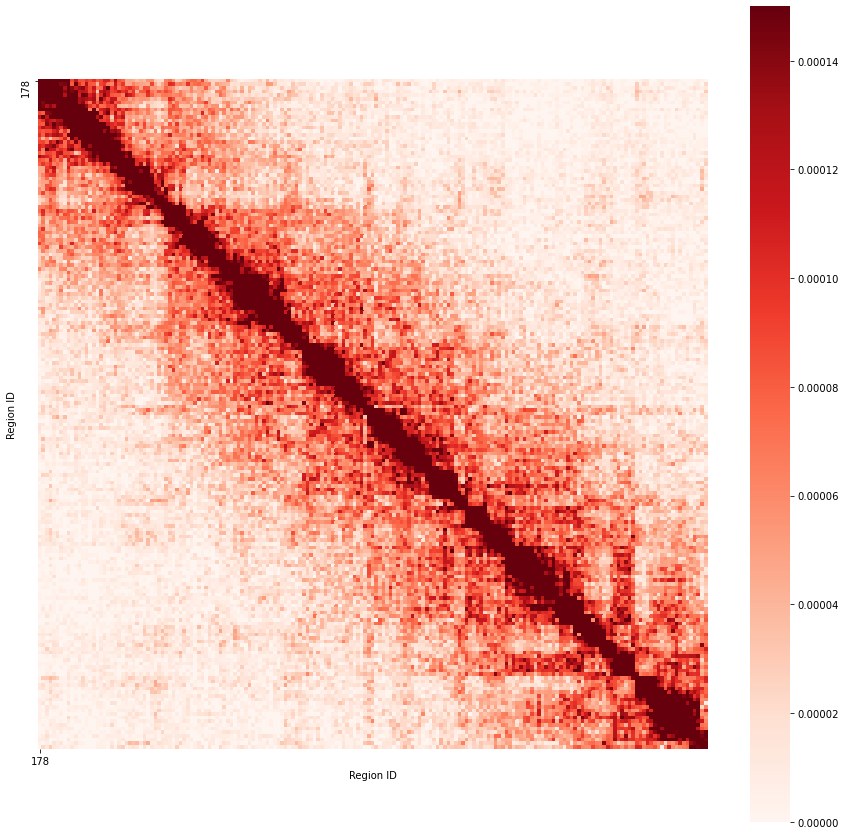

In [233]:
import seaborn as sns
plt.figure(figsize=(15, 15))
ax = sns.heatmap(
    thresh_df_norm.loc[(2,), (2,),],
    xticklabels=200, 
    yticklabels=200, 
    square=True,
    vmin=0, 
    vmax=1.5e-4,
    cmap='Reds'
)

# Interaction counting and normalization

In [20]:
pd

<module 'pandas' from '/home/lincoln/anaconda3/lib/python3.8/site-packages/pandas/__init__.py'>